# Schelling's Segregation Model

In [1]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

Before we start, look at [here](http://ncase.me/polygons/)

On this seminar we are implementing Schelling's Segregation Model for 2 classes.

To recall the model setting:
* Each node has a fixed threshold of neighbourhood tolerance. If the threshold is not violated a node is called satisfied
* Pick unsatisfied node
* Pick a distanation node, s.t. new utility valus is greater than the current one
* Move the chosen node to new destination, recalculate all utilities

We will run it no Knight Moves Network. However for the sake of demonstration it would be better to run it on Regular Lattice with 8 neighbours

In [2]:
def GenKnightNetwork(boardSize):
    G = nx.Graph()
    pos = {}
    for row in xrange(boardSize):
        for col in xrange(boardSize):
            nodeId = row + col*boardSize
            pos[nodeId] = np.array([1.0*row/boardSize, 1.0*col/boardSize])
            newPos = GetLegalMoves(row, col, boardSize)
            for e in newPos:
                nid = e[0] + e[1]*boardSize
                G.add_edge(nodeId, nid)
    return G, pos

def GetLegalMoves(x,y,boardSize):
    newMoves = []
    moveOffsets = [(-1,-2),(-1,2),(-2,-1),(-2,1),
                   ( 1,-2),( 1,2),( 2,-1),( 2,1)]
    for i in moveOffsets:
        newX = x + i[0]
        newY = y + i[1]
        if isLegalCoord(newX,boardSize) and \
                        isLegalCoord(newY,boardSize):
            newMoves.append((newX,newY))
    return newMoves

def isLegalCoord(x,boardSize):
    if x >= 0 and x < boardSize:
        return True
    else:
        return False

In [3]:
def SegregationModel(A, modelParams):
    
    # Grabbing model parameters
    dens = modelParams.get('density', 0.5)
    propA = modelParams.get('propA', 0.5)
    thresh = modelParams.get('threshold', 0.5)
    maxIters = modelParams.get('maxIters', 100)
    utilFunc = modelParams.get('utilFunc', 1)
    
    # Some initializations
    
    # Vertices Number
    V = A.shape[0]
    nAB = np.round(V*dens)
    nA = np.round(nAB*propA)
    nB = nAB - nA
    nE = V - nAB
    
    # Masks and Indices
    vAB,vA,vB,vE = np.zeros((V,1), dtype=bool),np.zeros((V,1), dtype=bool),np.zeros((V,1), dtype=bool),np.zeros((V,1), dtype=bool)

    idx = np.random.permutation(V)
    idxA = idx[0:nA]
    vA[idxA] = 1

    idxB = idx[nA:(nAB)]
    vB[idxB] = 1

    vE = ~(vA | vB)
    idxE = idx[(nAB):]

    idxAB = np.concatenate((idxA, idxB))
    
    # Calculate neighourhood types for the 1st step
    P = np.empty((V, maxIters))
    P[idxA,1] = 1.0*A[idxA,].dot(vB).flatten()/np.sum(A[idxA,], axis=1)
    P[idxB,1] = 1.0*A[idxB,].dot(vA).flatten()/np.sum(A[idxB,], axis=1)

    
    for t in xrange(1, maxIters):
        
        # Calculate all utilities
        utilAll = utilFunc(P[idxAB,t-1], thresh)
        
        # Check utility state
        if np.all(utilAll):
            break
        else: # Choose node to move
            utilCur = True
            while utilCur:
                idxFrom = np.random.choice(idxAB)
                utilCur = utilFunc(P[idxFrom, t-1], thresh)

            # Choose candidate node
            candP = np.empty((V,)) * np.nan
            if idxFrom in idxA:
                candP[idxE] = 1.0*A[idxE,].dot(vB).flatten()/np.sum(A[idxE,], axis=1)
            else:
                candP[idxE] = 1.0*A[idxE,].dot(vA).flatten()/np.sum(A[idxE,], axis=1)
            
            # Calculate candidate utility
            utilCand = utilFunc(candP, thresh)
                
            # Move node
            if np.any(utilCand > utilCur):
                idxTo = np.random.choice(np.where(utilCand > utilCur)[0])
                if idxFrom in idxA:
                    vA[idxFrom], vA[idxTo] = vA[idxTo], vA[idxFrom]
                    idxA[idxA == idxFrom] = idxTo
                else:
                    vB[idxFrom], vB[idxTo] = vB[idxTo], vB[idxFrom]
                    idxB[idxB == idxFrom] = idxTo
            
                idxAB[idxAB == idxFrom], idxE[idxE == idxTo] = idxTo, idxFrom
            
            # Update neighbourhood state
            P[idxA,t] = 1.0*A[idxA,].dot(vB).flatten()/np.sum(A[idxA,], axis=1)
            P[idxB,t] = 1.0*A[idxB,].dot(vA).flatten()/np.sum(A[idxB,], axis=1)

    print 'Finished on {0} iteration'.format(t)
    return vA.astype('double')+vB.astype('double')*2

In [7]:
# Getting the graph

g,pos = GenKnightNetwork(10)
A = np.asarray(nx.adj_matrix(g).todense())

Finished on 10 iteration


/home/shestakoff/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


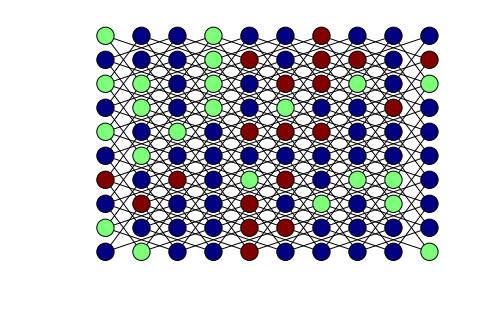

In [9]:
utilFunc = lambda x,p: x<p

modelParams = {}
modelParams['density'] = 0.5
modelParams['propA'] = 0.5
modelParams['threshold'] = 0.5
modelParams['maxIters'] = 100
modelParams['utilFunc'] = utilFunc

col = SegregationModel(A, modelParams)

nx.draw(g, pos=pos, node_color=col)

### Task

Implement Freeman's segregation, Schilling’s mixing coefficients and Assortative mixing coefficient.
Calculate values results for each iteration of the model.